In [1]:
pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


In [49]:
import numpy as np
import pandas as pd 

import pandas_datareader.data as web

# настройки визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import VAR 

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.utils.plotting import plot_series
from sktime.param_est.stationarity import StationarityADF, StationarityKPSS, StationarityDFGLS, \
StationarityPhillipsPerron, StationarityADFArch, StationarityKPSSArch

from sktime.forecasting.arch import ARCH
from sktime.utils.plotting import plot_series
# временной горизонт для прогнозирования
from sktime.forecasting.base import ForecastingHorizon
# Модули для кросс-валидации
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter, SlidingWindowSplitter, SingleWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError # Метрики MSE, MAE, MAPE

import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error as mse 
from pmdarima.arima import auto_arima 
# Не показывать Warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)

import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error as mse 


from arch import arch_model

from arch.univariate import ARX, GARCH, ARCHInMean 

# Скачиваем и обрабатываем данные

In [2]:
file_path = '/Users/macbook/Desktop/data_kursach.xlsx'

df = pd.read_excel(file_path, usecols='A:AI', skiprows=1, nrows=13)

In [3]:
df = df.rename(columns={'Unnamed: 0':'Month'})
df

,Month,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,январь,106.2,345.3,125.80,117.90,117.77,104.11,102.34,101.51,108.38,...,103.85,100.96,100.62,100.31,101.01,100.40,100.67,100.99,100.84,100.86
1,февраль,104.8,138.0,124.70,110.82,111.02,102.79,101.54,100.89,104.13,...,102.22,100.63,100.22,100.21,100.44,100.33,100.78,101.17,100.46,100.68
2,март,106.3,129.9,120.10,107.41,108.94,102.80,101.43,100.64,102.79,...,101.21,100.46,100.13,100.29,100.32,100.55,100.66,107.61,100.37,100.39
3,апрель,163.5,121.7,118.70,108.49,108.47,102.16,100.96,100.38,103.03,...,100.46,100.44,100.33,100.38,100.29,100.83,100.58,101.56,100.38,100.50
4,май,103.0,111.9,118.10,106.91,107.93,101.60,100.94,100.50,102.22,...,100.35,100.41,100.37,100.38,100.34,100.27,100.74,100.12,100.31,NaN
5,июнь,101.2,119.1,119.90,106.00,106.66,101.17,101.10,100.08,101.91,...,100.19,100.36,100.61,100.49,100.04,100.22,100.69,99.65,100.37,NaN
6,июль,100.6,110.6,122.39,105.33,105.38,100.72,100.93,100.17,102.82,...,100.80,100.54,100.07,100.27,100.20,100.35,100.31,99.61,100.63,NaN
7,август,100.5,108.6,126.00,104.62,104.56,99.79,99.86,103.67,101.16,...,100.35,100.01,99.46,100.01,99.76,99.96,100.17,99.48,100.28,NaN
8,сентябрь,101.1,111.5,123.00,107.96,104.46,100.33,99.70,138.43,101.48,...,100.57,100.17,99.85,100.16,99.84,99.93,100.60,100.05,100.87,NaN
9,октябрь,103.5,122.9,119.50,115.00,104.72,101.20,100.17,104.54,101.37,...,100.74,100.43,100.20,100.35,100.13,100.43,101.11,100.18,100.83,NaN


In [4]:
df_melted = pd.melt(df, id_vars=['Month'], var_name='Year', value_name='Value')
df_melted = df_melted.dropna()
df_melted = df_melted[df_melted['Year']>1999]
df_melted.reset_index(inplace=True)

df_melted.columns.values[1] = 'month'
df_melted.columns.values[2] = 'year'
df_melted.columns.values[3] = 'value'

y = df_melted['value']

df_melted.head()

,index,month,year,value
0,108,январь,2000,102.33
1,109,февраль,2000,101.04
2,110,март,2000,100.64
3,111,апрель,2000,100.89
4,112,май,2000,101.75


In [5]:
# Создаём словарь для перевода месяцев
month_translation = {
    'январь': 'January',
    'февраль': 'February',
    'март': 'March',
    'апрель': 'April',
    'май': 'May',
    'июнь': 'June',
    'июль': 'July',
    'август': 'August',
    'сентябрь': 'September',
    'октябрь': 'October',
    'ноябрь': 'November',
    'декабрь': 'December'
}

# Применяем словарь для перевода месяцев
df_melted['month'] = df_melted['month'].map(month_translation)


# Создаем столбец 'date' из 'month' и 'year'
df_melted['date'] = pd.to_datetime(df_melted['month'] + ' ' + df_melted['year'].astype(str), format='%B %Y')

df_melted = df_melted[['date', 'value']]

df_melted

,date,value
0,2000-01-01,102.33
1,2000-02-01,101.04
2,2000-03-01,100.64
3,2000-04-01,100.89
4,2000-05-01,101.75
...,...,...
287,2023-12-01,100.73
288,2024-01-01,100.86
289,2024-02-01,100.68
290,2024-03-01,100.39


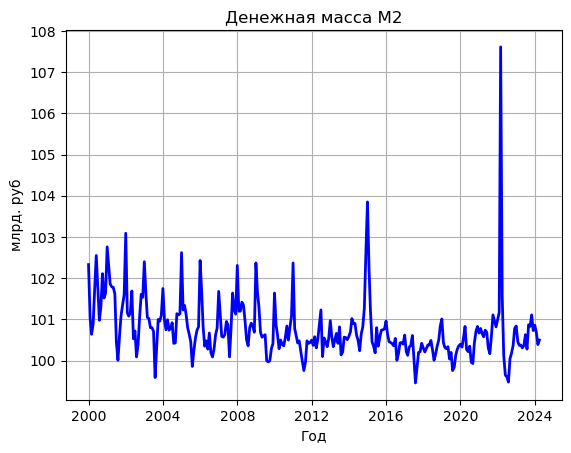

In [6]:
plt.plot(df_melted['date'], df_melted['value'], color='blue', linewidth=2, label='m2')
plt.title('Денежная масса M2')
plt.xlabel('Год')
plt.ylabel('млрд. руб')
plt.grid(True)
plt.show()

Проводим UR тесты

ADF тест

In [7]:
sty_est = StationarityADF(p_threshold=0.05, regression='c', autolag='BIC')
sty_est.fit(y)
sty_est.get_fitted_params()

{'pvalue': 1.4551270806449067e-16,
 'stationary': True,
 'test_statistic': -9.648596197009347,
 'used_lag': 0}

KPSS тест

In [8]:
sty_est = StationarityKPSS(p_threshold=0.05, regression='c')
sty_est.fit(y)
sty_est.get_fitted_params()

{'lags': 7,
 'pvalue': 0.01,
 'stationary': False,
 'test_statistic': 1.2385687962083824}

Продифференциируем временной ряд и проведём тест на стационарность ещё раз

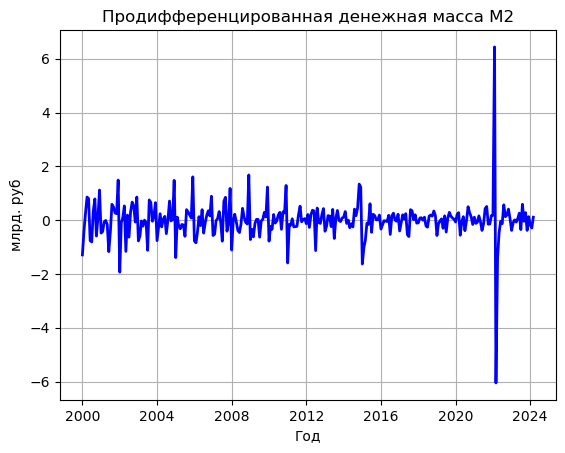

In [9]:
plt.plot(df_melted['date'].head(291), y.diff().dropna(), color='blue', linewidth=2, label='m2')
plt.title('Продифференцированная денежная масса M2')
plt.xlabel('Год')
plt.ylabel('млрд. руб')
plt.grid(True)
plt.show()

ADF тест

In [10]:
sty_est = StationarityADF(p_threshold=0.05, regression='c', autolag='BIC')
sty_est.fit(y.diff().dropna())
sty_est.get_fitted_params()

{'pvalue': 8.71330409468198e-20,
 'stationary': True,
 'test_statistic': -10.95276497557031,
 'used_lag': 10}

KPSS тест

In [11]:
sty_est = StationarityKPSS(p_threshold=0.05, regression='c')
sty_est.fit(y.diff().dropna())
sty_est.get_fitted_params()

{'lags': 32,
 'pvalue': 0.1,
 'stationary': True,
 'test_statistic': 0.1016203300359189}

# ARIMA

In [12]:
forecaster = AutoARIMA(start_p=1, start_q=1, max_p=5, max_q=5, stationary=False, information_criterion='bic',
                       trend='c', seasonal=False)
forecaster.fit(y)
forecaster.get_fitted_params()

{'intercept': -0.002939207298790226,
 'ma.L1': -0.5101664267454571,
 'ma.L2': -0.2907899447978645,
 'ma.L3': -0.1675708929669454,
 'sigma2': 0.3899609868975293,
 'order': (0, 1, 3),
 'seasonal_order': (0, 0, 0, 0),
 'aic': 564.3313858053399,
 'aicc': 564.5419121211294,
 'bic': 582.6980021411973,
 'hqic': 571.6891364071544}

# SARIMA

In [13]:
forecaster = AutoARIMA(information_criterion='bic', seasonal=True, sp=12)
forecaster.fit(y.diff().dropna())
forecaster.get_fitted_params()
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  291
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -249.887
Date:                            Sun, 23 Jun 2024   AIC                            509.773
Time:                                    19:51:01   BIC                            528.140
Sample:                                         0   HQIC                           517.131
                                            - 291                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4555      0.028     16.144      0.000       0.400       0.511
ma.L1         -0.9812      0.019    -51.223      0.000      -1.019      -0.944
ar.S.L12       0.9704      0.018     52.866      0.000       0.934       1.006
ma.S.L12      -0.8437      0.046    -18.535      0.000      -0.933      -0.754
sigma2         0.3155      0.005     68.727      0.000       0.307       0.325
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             73992.53
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               3.72   Skew:                             6.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        80.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARIMAX

Данные взяты с сайта https://ru.investing.com/commodities/brent-oil-historical-data

Проводим подготовку данных с котировками цена на нефть

In [14]:
df_brent = pd.read_csv('/Users/macbook/Desktop/Brent.csv')
df_brent = df_brent[['Дата', 'Цена']]

df_brent['Цена'] = df_brent['Цена'].str.replace(',','.')
df_brent['Цена'] = df_brent['Цена'].astype(float)
df_brent = df_brent.rename(columns={'Дата':'date',
                                    'Цена':'price'})

df_brent['date'] = pd.to_datetime(df_brent['date'])
df_brent = df_brent[df_brent['date'] < '2024-01-05']
df_brent.reset_index(inplace=True)

x = df_brent['price']

df_brent = df_brent.drop('index', axis=1)
df_brent['date'] = pd.to_datetime(df_brent['date'])

df_brent

,date,price
0,2024-01-04,86.33
1,2024-01-03,87.48
2,2024-01-02,81.91
3,2024-01-01,80.55
4,2023-01-12,77.04
...,...,...
287,2000-01-05,28.31
288,2000-01-04,23.89
289,2000-01-03,24.77
290,2000-01-02,28.09


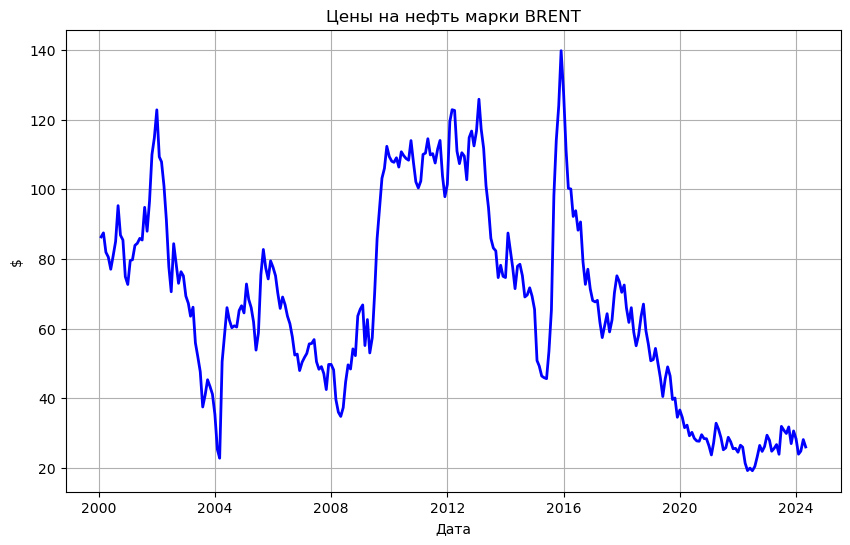

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(pd.date_range(start='2000-01', end='2024-05', freq='M'),
         x,  
         linestyle='-',  
         linewidth=2,
         color='blue')  

# Добавление заголовка графика
plt.title('Цены на нефть марки BRENT')

# Добавление подписей к осям
plt.xlabel('Дата')  # Подпись для оси X
plt.ylabel('$')  # Подпись для оси Y

# Включение сетки для улучшения восприятия данных
plt.grid(True)  # True активирует отображение сетки на графике

# Отображение графика
plt.show()
 

Проводим UR тесты

ADF тест

In [16]:
sty_est = StationarityADF(p_threshold=0.05, regression='c', autolag='BIC')
sty_est.fit(x)
sty_est.get_fitted_params()

{'pvalue': 0.19141598830961987,
 'stationary': False,
 'test_statistic': -2.241827780433614,
 'used_lag': 1}

KPSS тест

In [17]:
sty_est = StationarityKPSS(p_threshold=0.05, regression='c')
sty_est.fit(x)
sty_est.get_fitted_params()

{'lags': 10,
 'pvalue': 0.01,
 'stationary': False,
 'test_statistic': 0.7767996555843024}

Временной ряд не стационарен, продифференциируем временной ряд и проведём тест ещё раз

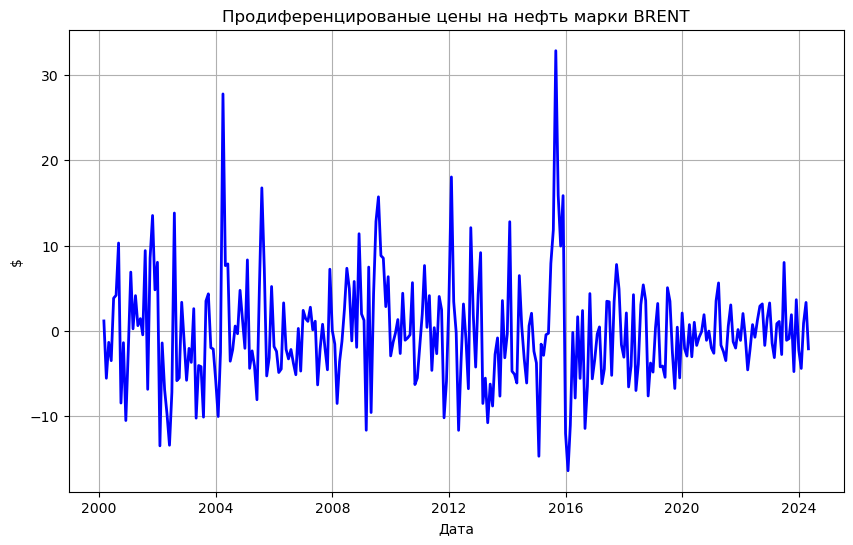

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(pd.date_range(start='2000-02', end='2024-05', freq='M'),
         x.diff().dropna(),  # color отвечает за цвет линии
         linestyle='-',  # linestyle определяет стиль линии
         linewidth=2,
         color='blue')  # linewidth задаёт толщину линии

# Добавление заголовка графика
plt.title('Продиференцированые цены на нефть марки BRENT')

# Добавление подписей к осям
plt.xlabel('Дата')  # Подпись для оси X
plt.ylabel('$')  # Подпись для оси Y

# Включение сетки для улучшения восприятия данных
plt.grid(True)  # True активирует отображение сетки на графике

# Отображение графика
plt.show()
 

ADF тест

In [19]:
sty_est = StationarityADF(p_threshold=0.05, regression='c', autolag='BIC')
sty_est.fit(x.diff().dropna())
sty_est.get_fitted_params()

{'pvalue': 1.3023439415493756e-24,
 'stationary': True,
 'test_statistic': -13.161877878474245,
 'used_lag': 0}

KPSS тест

In [20]:
sty_est = StationarityKPSS(p_threshold=0.05, regression='c')
sty_est.fit(x.diff().dropna())
sty_est.get_fitted_params()

{'lags': 3,
 'pvalue': 0.1,
 'stationary': True,
 'test_statistic': 0.05112216469273167}

Построим модель ARIMAX

In [21]:
forecaster_arimax = AutoARIMA(start_p=1, start_q=1, max_p=5, max_q=5, stationary=False,
                       information_criterion='bic', trend='c', seasonal=False)
forecaster_arimax.fit(y, x)
forecaster_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -280.874
Date:                Sun, 23 Jun 2024   AIC                            571.748
Time:                        19:51:02   BIC                            590.114
Sample:                             0   HQIC                           579.105
                                - 292                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0037      0.003     -1.136      0.256      -0.010       0.003
price         -0.0036      0.003     -1.121      0.262      -0.010       0.003
ma.L1         -0.5750      0.034    -16.770      0.000      -0.642      -0.508
ma.L2         -0.3784      0.053     -7.092      0.000      -0.483      -0.274
sigma2         0.4004      0.012     34.274      0.000       0.378       0.423
===================================================================================
Ljung-Box (L1) (Q):                   1.64   Jarque-Bera (JB):             30084.52
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                             4.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Построим модель SARIMAX

In [22]:
forecaster_arimax = AutoARIMA(start_p=1, start_q=1, max_p=5, max_q=5, stationary=False,
                       information_criterion='bic', trend='c', seasonal=True)
forecaster_arimax.fit(y, x)
forecaster_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -280.874
Date:                Sun, 23 Jun 2024   AIC                            571.748
Time:                        19:51:03   BIC                            590.114
Sample:                             0   HQIC                           579.105
                                - 292                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0037      0.003     -1.136      0.256      -0.010       0.003
price         -0.0036      0.003     -1.121      0.262      -0.010       0.003
ma.L1         -0.5750      0.034    -16.770      0.000      -0.642      -0.508
ma.L2         -0.3784      0.053     -7.092      0.000      -0.483      -0.274
sigma2         0.4004      0.012     34.274      0.000       0.378       0.423
===================================================================================
Ljung-Box (L1) (Q):                   1.64   Jarque-Bera (JB):             30084.52
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.86   Skew:                             4.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        51.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# GARCH

In [23]:
forecaster_garch = ARCH(mean='ARX', lags=1, vol='GARCH', p=0, q=3, power=1)  
forecaster_garch.fit(y)

forecaster_garch.summary()

ValueError: One of p or o must be strictly positive

# Var модель

Для модели VAR возьмём такие факторы, как: 
денежная масса m2 (https://www.cbr.ru/search/?text=m2),
процентная ставка ЦБ (https://www.cbr.ru/hd_base/infl/),
цены на нефть BRENT

## M2

Скачиваем и обраюатываем данные о денежной массе m2

In [24]:
m2 = pd.read_excel('/Users/macbook/Desktop/M2-M2_SA.xlsx', usecols='A:C', skiprows=1, nrows=348)
m2 = m2.rename(columns={'М2':'m2',
                   'Date':'date'})

columns = m2.columns.tolist()
columns[2] = 'm2_sa'
m2 = m2.set_axis(columns, axis=1)

m2.head()

,date,m2,m2_sa
0,1995-07-01,156.6,152.643868
1,1995-08-01,165.0,162.274119
2,1995-09-01,173.8,173.345276
3,1995-10-01,179.7,182.047566
4,1995-11-01,184.1,186.085798


In [25]:
m2 = m2[(m2['date'].dt.year>1999) & (m2['date'] != '2024-05-01')]
len(m2)

292

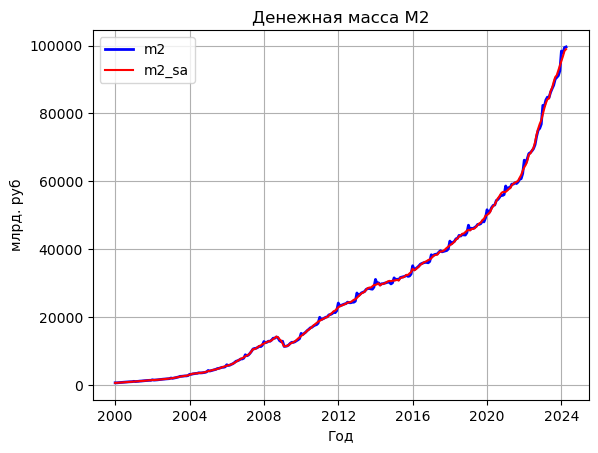

In [26]:
plt.plot(m2['date'], m2['m2'], color='blue', linewidth=2, label='m2')
plt.title('Денежная масса M2')
plt.xlabel('Год')
plt.ylabel('млрд. руб')
plt.grid(True)

plt.plot(m2['date'], m2['m2_sa'], color='red', label='m2_sa')
plt.legend()
plt.show() 

Возьмём сезонно скоректированное значение m2

In [27]:
m2_sa = m2['m2_sa']

Проведём проверку временного ряда на стационарность

ADF тест

In [28]:
sty_est = StationarityADF(p_threshold=0.05, regression='ct', autolag='BIC')
sty_est.fit(m2_sa)
sty_est.get_fitted_params()

{'pvalue': 1.0,
 'stationary': False,
 'test_statistic': 3.896478690307912,
 'used_lag': 2}

KPSS тест

In [29]:
sty_est = StationarityKPSS(p_threshold=0.05, regression='ct')
sty_est.fit(m2_sa)
sty_est.get_fitted_params()

{'lags': 10,
 'pvalue': 0.01,
 'stationary': False,
 'test_statistic': 0.5116100236822421}

Временной ряд не стационарен, попробуем прологарифмировать его

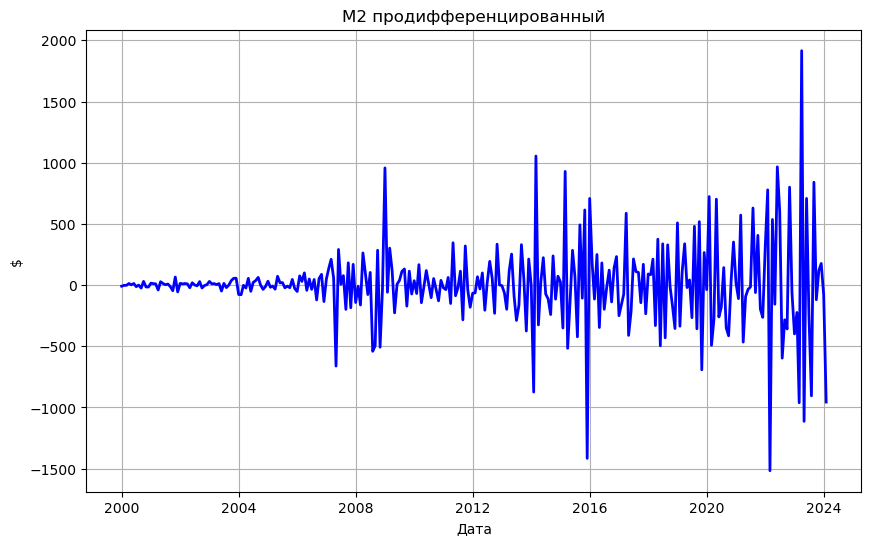

In [30]:
m2_sa_diff = m2_sa.diff().diff().dropna()

plt.figure(figsize=(10, 6))
plt.plot(m2['date'].head(290),
         m2_sa_diff,  
         linestyle='-',  
         linewidth=2,
         color='blue')  

# Добавление заголовка графика
plt.title('M2 продифференцированный')

# Добавление подписей к осям
plt.xlabel('Дата')  # Подпись для оси X
plt.ylabel('$')  # Подпись для оси Y

# Включение сетки для улучшения восприятия данных
plt.grid(True)  # True активирует отображение сетки на графике

# Отображение графика
plt.show()
 

ADF тест

In [31]:
sty_est = StationarityADF(p_threshold=0.05, regression='ct', autolag='BIC')
sty_est.fit(m2_sa_diff)
sty_est.get_fitted_params()

{'pvalue': 4.700227157483816e-22,
 'stationary': True,
 'test_statistic': -14.453910972579061,
 'used_lag': 3}

KPSS тест

In [32]:
sty_est = StationarityKPSS(p_threshold=0.05, regression='ct')
sty_est.fit(m2_sa_diff)
sty_est.get_fitted_params()

{'lags': 44,
 'pvalue': 0.1,
 'stationary': True,
 'test_statistic': 0.07767497177260253}

Ряд стал стационарным при дифференциации второй степени

## Ключевая ставка

In [33]:
interest_rate = pd.read_excel('/Users/macbook/Desktop/interest_rate.xlsx',
                              usecols='A:C', skiprows=0, nrows=126)

interest_rate = interest_rate.rename(columns={'Дата':'date',
                                              'Ключевая ставка, % годовых':'interest_rate',
                                              'Инфляция, % г/г':'inflation'})

interest_rate

,date,interest_rate,inflation
0,5.2024,16.0,8.30
1,4.2024,16.0,7.84
2,3.2024,16.0,7.72
3,2.2024,16.0,7.69
4,1.2024,16.0,7.44
...,...,...,...
120,5.2014,7.5,7.59
121,4.2014,7.5,7.33
122,3.2014,7.0,6.92
123,2.2014,5.5,6.21


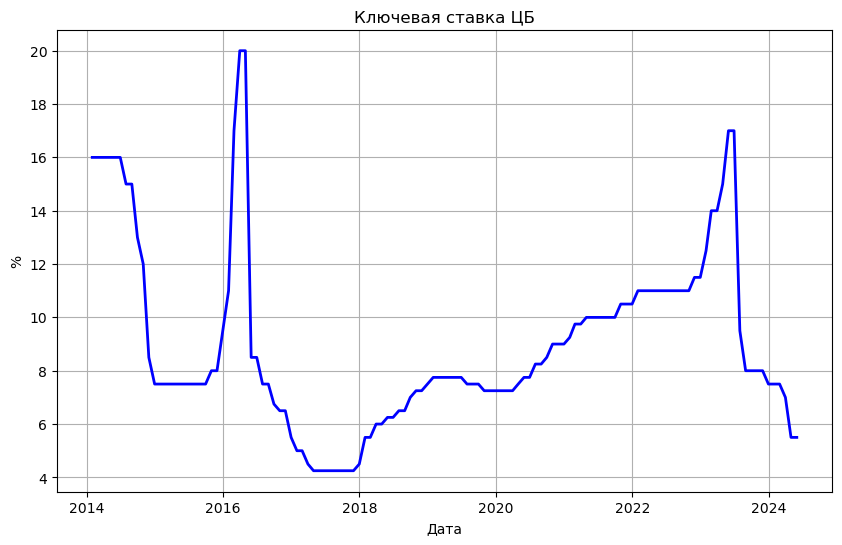

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(pd.date_range(start='2014-01', end='2024-06', freq='M'),
         interest_rate['interest_rate'],  
         linestyle='-',  
         linewidth=2,
         color='blue')  

# Добавление заголовка графика
plt.title('Ключевая ставка ЦБ')

# Добавление подписей к осям
plt.xlabel('Дата')  # Подпись для оси X
plt.ylabel('%')  # Подпись для оси Y

# Включение сетки для улучшения восприятия данных
plt.grid(True)  # True активирует отображение сетки на графике

# Отображение графика
plt.show()
 

ADF тест

In [35]:
sty_est = StationarityADF(p_threshold=0.05, regression='c', autolag='BIC')
sty_est.fit(interest_rate['interest_rate'])
sty_est.get_fitted_params()

{'pvalue': 0.009062136121974568,
 'stationary': True,
 'test_statistic': -3.4604748721215604,
 'used_lag': 1}

KPSS тест

In [36]:
sty_est = StationarityKPSS(p_threshold=0.05, regression='c')
sty_est.fit(interest_rate['interest_rate'])
sty_est.get_fitted_params()

{'lags': 6,
 'pvalue': 0.1,
 'stationary': True,
 'test_statistic': 0.23439470973091592}

# VAR

In [37]:
interest_rate = interest_rate['interest_rate']
interest_rate

0      16.0
1      16.0
2      16.0
3      16.0
4      16.0
       ... 
120     7.5
121     7.5
122     7.0
123     5.5
124     5.5
Name: interest_rate, Length: 125, dtype: float64

Возьмём правильный диапазон для данных, так как данные по ключевой ставке начинаются с 2014 года.

In [38]:
m2_sa_diff = m2_sa_diff.head(125)
m2_sa_diff = m2_sa_diff.reset_index()
m2_sa_diff = m2_sa_diff['m2_sa']
m2_sa_diff

0       -9.397479
1       -2.565082
2       -2.455893
3       12.401417
4        2.058866
          ...    
120     35.461202
121    -69.200500
122    166.482033
123   -144.237963
124    -19.688134
Name: m2_sa, Length: 125, dtype: float64

In [39]:
x_diff = x.diff().dropna().head(125)
x_diff=x_diff.reset_index()
x_diff = x_diff['price']
x_diff

0      1.15
1     -5.57
2     -1.36
3     -3.51
4      3.82
       ... 
120   -0.31
121    1.31
122   -2.67
123    4.40
124   -1.11
Name: price, Length: 125, dtype: float64

In [40]:
y_diff = y.diff().dropna().head(125)
y_diff = y_diff.reset_index()
y_diff = y_diff['value']
y_diff

0     -1.29
1     -0.40
2      0.25
3      0.86
4      0.80
       ... 
120   -0.78
121   -0.23
122   -0.34
123    0.21
124   -0.11
Name: value, Length: 125, dtype: float64

Построим модель VAR

In [44]:
V = pd.DataFrame({'price_index':y_diff,
                  'm2_sa_diff':m2_sa_diff,
                  'brent':x_diff,
                  'interest_rate':interest_rate})
V

,price_index,m2_sa_diff,brent,interest_rate
0,-1.29,-9.397479,1.15,16.0
1,-0.40,-2.565082,-5.57,16.0
2,0.25,-2.455893,-1.36,16.0
3,0.86,12.401417,-3.51,16.0
4,0.80,2.058866,3.82,16.0
...,...,...,...,...
120,-0.78,35.461202,-0.31,7.5
121,-0.23,-69.200500,1.31,7.5
122,-0.34,166.482033,-2.67,7.0
123,0.21,-144.237963,4.40,5.5


### Подгонка VAR "оптимального" порядка

In [45]:
mod = VAR(V, missing='drop')

res = mod.fit(maxlags=2, ic='bic', trend='c')

res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 23, Jun, 2024
Time:                     20:00:52
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    14.2051
Nobs:                     124.000    HQIC:                   13.9350
Log likelihood:          -1536.31    FPE:                    936975.
AIC:                      13.7502    Det(Omega_mle):         799937.
--------------------------------------------------------------------
Results for equation price_index
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.057896         0.154346            0.375           0.708
L1.price_index          -0.179084         0.089299           -2.005           0.045
L1.m2_sa_diff           -0.000457         

### Визуализация для подогнанной модели

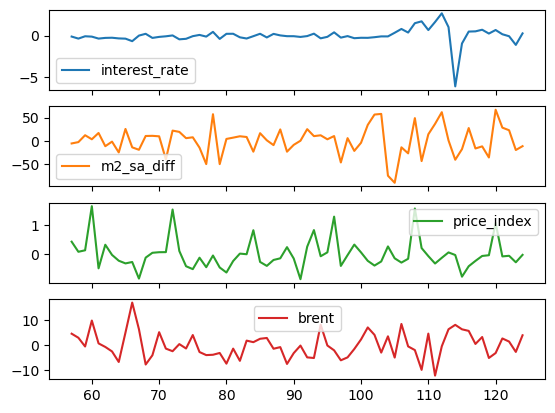

In [335]:
res.resid.plot(subplots=True)

plt.show()

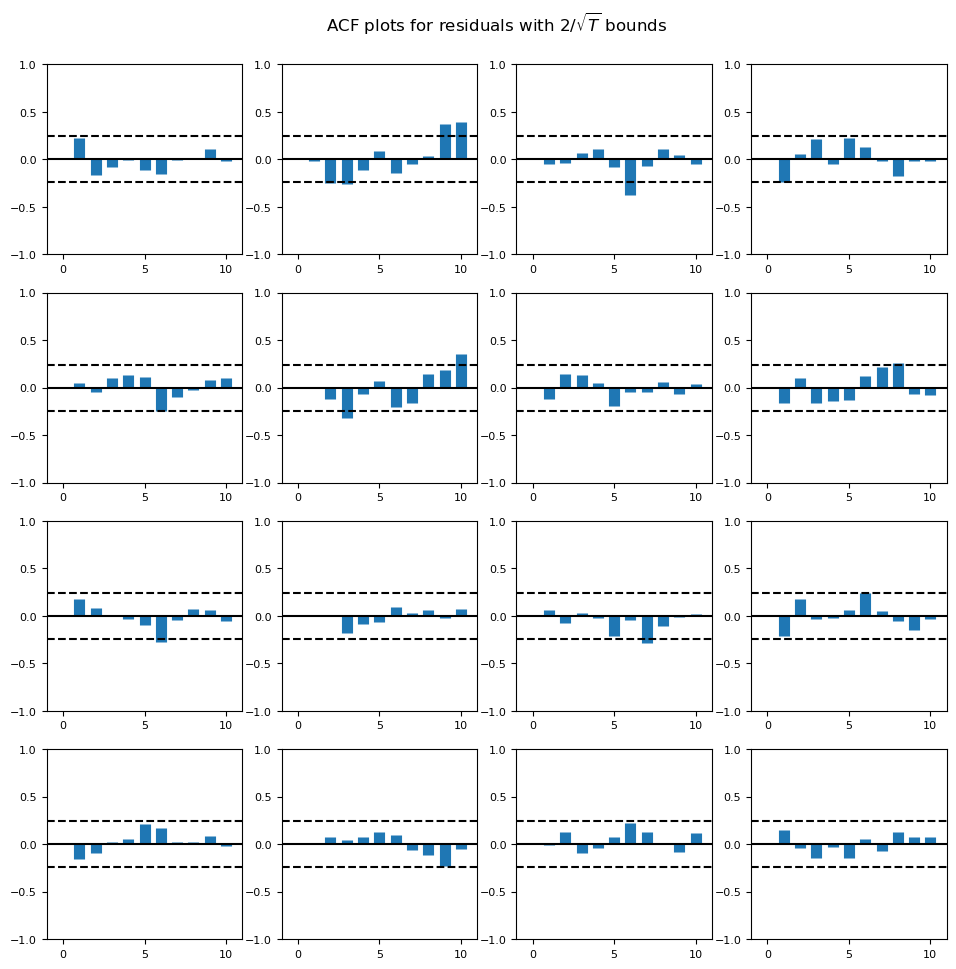

In [336]:
# ACF для остатков
res.plot_acorr()
plt.show()

### Диагностика модели

In [337]:
# тест на серийную корреляцию
res.test_whiteness(nlags=10, signif=0.05, adjusted=True).summary()

Test statistic,Critical value,p-value,df
179.9,173.0,0.023,144


### Прогнозирование

In [46]:
# преобразуем y в формат numpy
res.forecast(y=y.tail(res.k_ar).values, steps=10)

ValueError: could not broadcast input array from shape (4,4) into shape (4,)

### IRF

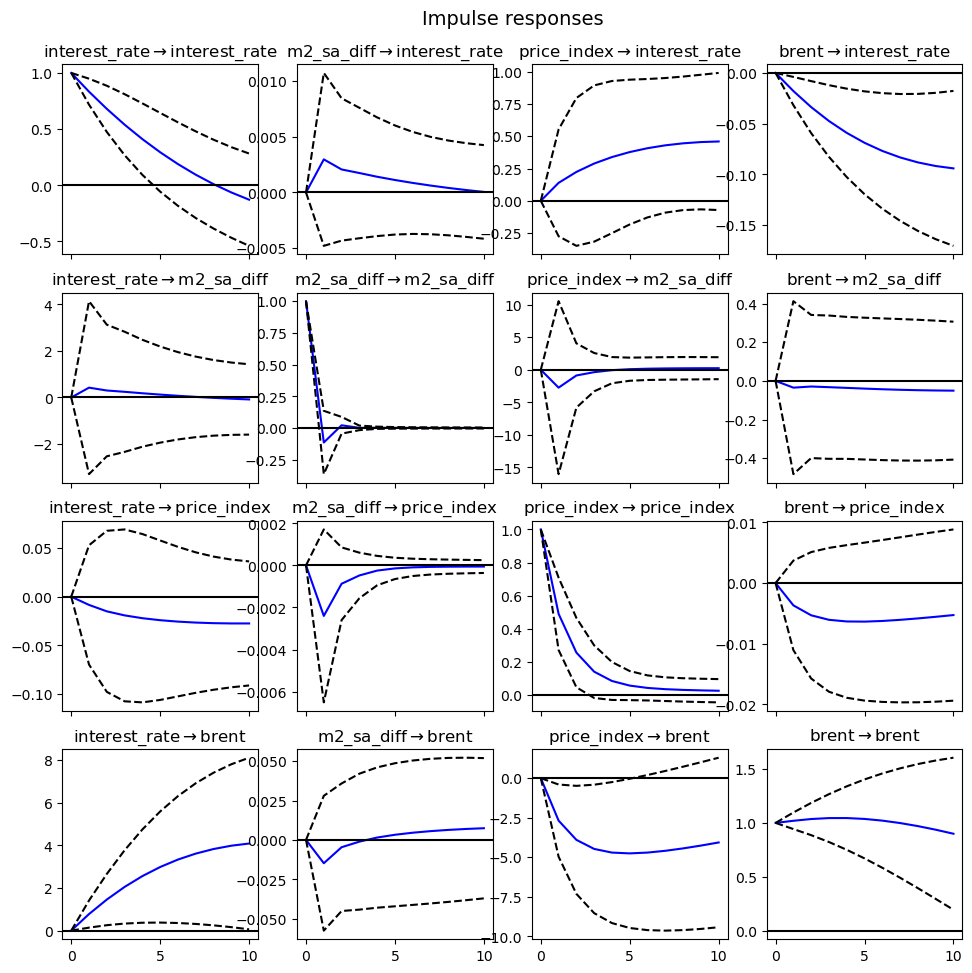

In [341]:
res.irf(periods=10).plot(signif=0.05)
plt.show()

### FEVD

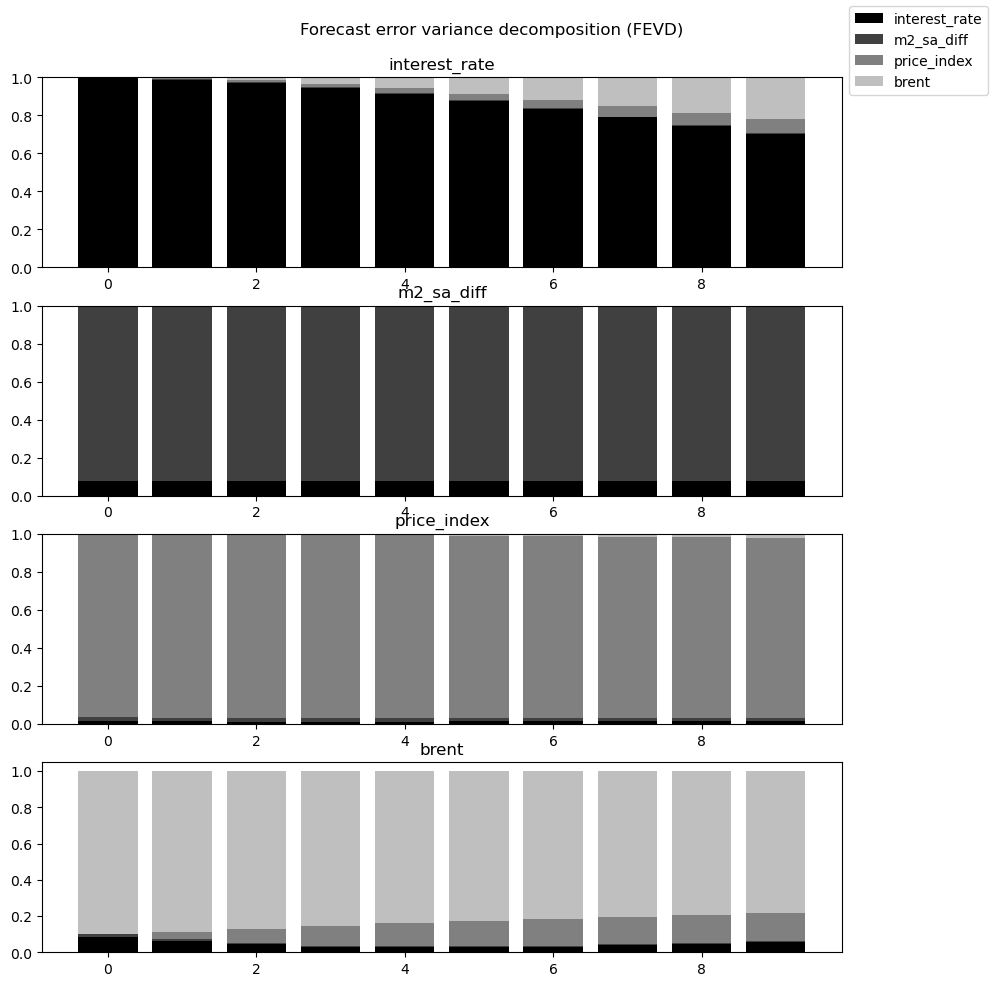

In [342]:
res.fevd(periods=10).plot()

plt.show()

# Кросс-валидация

In [68]:
# специфицируем модель
arima = pm.ARIMA(order=(0,1,3), trend='c')

# специфицируем метод кросс-валидации: h - горизонт прогнозирования, step - шаг увеличения обучающей выборки.
# по умолчанию начинаем с 1/3 выборки
cv = model_selection.RollingForecastCV(h=5, step=5)

# считаем метрику для прогнозов (MSE) для каждой итерации (verbose выдаёт отчёт по каждой итерации)
scores = model_selection.cross_val_score(estimator=arima, y=y, cv=cv, scoring='mean_squared_error', verbose=2)

# средняя ошибка
np.average(scores)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

0.7635836319205966

<function matplotlib.pyplot.show(close=None, block=None)>

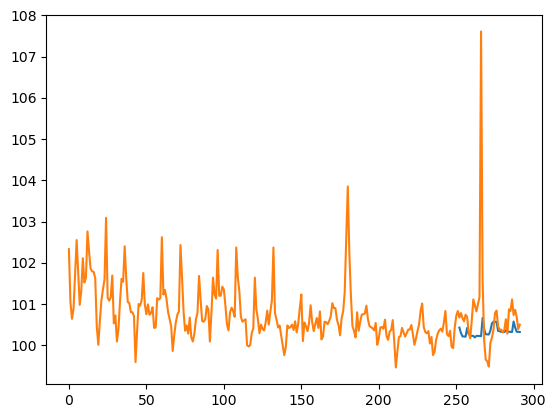

In [58]:
cv = model_selection.RollingForecastCV(h=5, step=5, initial=250)

predictions = model_selection.cross_val_predict(arima, y, cv=cv, verbose=0, averaging="mean")

n_test = predictions.shape[0]

predictions = pd.DataFrame(predictions, index=y.index[-n_test:])

plt.plot(predictions)
plt.plot(y)

plt.show

Кросс-валидация ARIMAX

In [62]:
# специфицируем модель
arimax = auto_arima(y, exogenous=x, seasonal=False)

In [64]:
# специфицируем метод кросс-валидации: h - горизонт прогнозирования, step - шаг увеличения обучающей выборки.
# по умолчанию начинаем с 1/3 выборки
cv = model_selection.RollingForecastCV(h=5, step=5)

# считаем метрику для прогнозов (MSE) для каждой итерации (verbose выдаёт отчёт по каждой итерации)
scores = model_selection.cross_val_score(estimator=arimax, y=y, cv=cv, scoring='mean_squared_error', verbose=2)

# средняя ошибка
np.average(scores)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
[CV] fold=8 ..........................................................
[CV] fold=9 ..........................................................
[CV] fold=10 .........................................................
[CV] fold=11 .........................................................
[CV] fold=12 .........................................................
[CV] fold=13 .........................................................
[CV] f

0.7635836319205966

<function matplotlib.pyplot.show(close=None, block=None)>

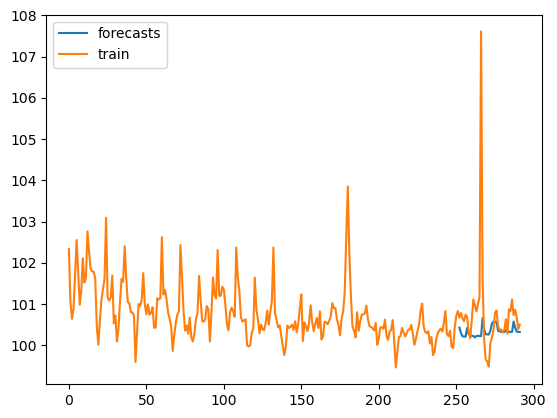

In [67]:
cv = model_selection.RollingForecastCV(h=5, step=5, initial=250)

predictions = model_selection.cross_val_predict(arimax, y, cv=cv, verbose=0, averaging="mean")

n_test = predictions.shape[0]

predictions = pd.DataFrame(predictions, index=y.index[-n_test:])


plt.plot(predictions)
plt.plot(y)
plt.legend(['forecasts', 'train', 'test'])

plt.show